In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

train_df = pd.read_csv('./mnist/train/train.csv')
train_labels = train_df['label']
train_data = train_df.drop("label",axis=1)

## Covariance Matrix

In [228]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(train_data)
covar_matrix = np.matmul(standardized_data.T , standardized_data)

## Eigen Decomposition and Projection

In [232]:
from scipy.linalg import eigh 
values, vectors = eigh(covar_matrix, eigvals=(standardized_data.shape[1]-2,standardized_data.shape[1]-1))
vectors = vectors.T
projected_data = np.matmul(vectors[0,:], standardized_data.T)
label_binary = labels.replace([2,3,4,5,6,7,8,9],0).to_numpy() # retain label 1 only
data_bind = np.vstack((projected_data, label_binary)).T
ind_1 = data_bind[:, 0].argsort()
data_bind_sorted = data_bind[ind_1]

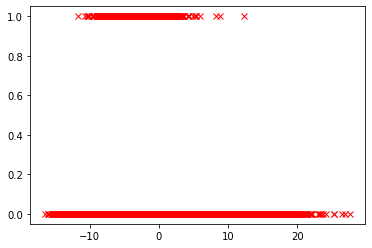

In [233]:
plt.plot(data_bind_sorted[:,0],data_bind_sorted[:,1],'rx')

In [158]:
with open('mnist_data_train.txt', 'w') as file:
    for data in data_bind_sorted:
        data = list(map(str, data))
        file.writelines(','.join(data)+'\n')

# Optional: PCA from Sklearn 

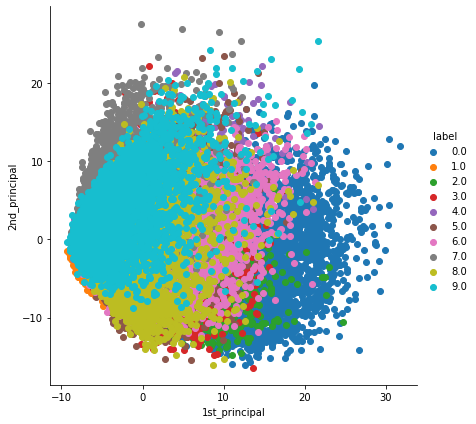

In [234]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.n_components = 2
pca_data = pca.fit_transform(standardized_data)
pca_data = np.vstack((pca_data.T, labels)).T
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))
sn.FacetGrid(pca_df, hue="label", height=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.show()

## Neural Networks

In [326]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
import time, random

In [327]:
SEED = 37

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [331]:
# train
train_labels = train_df["label"].values
train_images = (train_df.iloc[:, 1:].values).astype("float32")

train_images = train_images.reshape(train_images.shape[0], 28, 28)
train_images_tensor = torch.tensor(train_images)/255.0
train_labels_tensor = torch.tensor(train_labels)
# use the sorted training set for validation of frequency principle
test_freq_images_tensor = train_images_tensor[ind_1]
test_freq_labels_tensor = train_labels_tensor[ind_1]
test_freq_tensor = TensorDataset(test_freq_images_tensor, test_freq_labels_tensor)
test_freq_loader = DataLoader(test_freq_tensor, batch_size=32, num_workers=8, shuffle=False)
# train validation split
train_images_tensor, val_images_tensor, train_labels_tensor, val_labels_tensor = train_test_split(train_images_tensor, train_labels_tensor, stratify=train_labels_tensor,
                                                                     random_state=SEED, test_size=0.20)

train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)
train_loader = DataLoader(train_tensor, batch_size=32, num_workers=8, shuffle=True)
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor)
val_loader = DataLoader(val_tensor, batch_size=32, num_workers=8, shuffle=True)

In [332]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x


def train_model(conv_model, data_loader, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    conv_model.train()
    #print(f"learning rate is {optimizer.param_groups[0]['lr']}")

    for (x, y) in data_loader:
        x = x.unsqueeze(1)
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = conv_model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        acc = calculate_accuracy(y_pred, y)
        epoch_acc += acc.item()
        
    epoch_loss /= len(data_loader)
    epoch_acc /= len(data_loader)
    return epoch_loss, epoch_acc
        
        
def evaluate(conv_model, data_loader, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    
    conv_model.eval()
    
    with torch.no_grad():
        for (x, y) in data_loader:
            x = x.unsqueeze(1)
            x = x.to(device)
            y = y.to(device)
            y_pred = conv_model(x)     
            loss = criterion(y_pred, y)
            epoch_loss += loss.item()
            acc = calculate_accuracy(y_pred, y)
            epoch_acc += acc.item()
        
    epoch_loss /= len(data_loader)
    epoch_acc /= len(data_loader)
    return epoch_loss, epoch_acc
   
    
def make_predictions(conv_model, data_loader, device):
    conv_model.eval()
    test_preds = torch.LongTensor()
    
    with torch.no_grad():
        for (x, y) in data_loader:
            x = x.unsqueeze(1)
            x = x.to(device)
            y_pred = conv_model(x)
            preds = y_pred.cpu().data.max(1, keepdim=True)[1]
            test_preds = torch.cat((test_preds, preds), dim=0)
    return test_preds

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def calculate_accuracy(y_pred, y):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(1, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        acc = correct / batch_size
    return acc

In [333]:
conv_model = Net()
optimizer = optim.Adam(params=conv_model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
conv_model = conv_model.to(device)
criterion = criterion.to(device)

In [334]:
num_epochs = 20

for epoch in range(num_epochs):
    start_time = time.monotonic()
    train_loss, train_acc = train_model(conv_model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(conv_model, val_loader, criterion, device)
    lr_scheduler.step()
    # save test results for validation of frequency principle
    test_freq_set_preds = make_predictions(conv_model, test_freq_loader, device)
    label_pred_binary = test_freq_set_preds.numpy()
    label_pred_binary[label_pred_binary != 1] = 0 # only retain class 1
    file_name = 'mnist_data_predict_epoch_'+str(n)+'.txt'
    with open(file_name, 'w') as file:
        for data in label_pred_binary:
            data = list(map(str, data))
            file.writelines(','.join(data)+'\n')
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc*100:6.2f}% | ')
    print(f'\tValid Loss: {val_loss:.3f} | Valid Acc @1: {val_acc*100:6.2f}% | ')

Epoch: 01 | Epoch Time: 0m 56s
	Train Loss: 0.350 | Train Acc @1:  90.26% | 
	Valid Loss: 0.062 | Valid Acc @1:  98.08% | 
Epoch: 02 | Epoch Time: 0m 55s
	Train Loss: 0.165 | Train Acc @1:  95.30% | 
	Valid Loss: 0.056 | Valid Acc @1:  98.44% | 
Epoch: 03 | Epoch Time: 0m 55s
	Train Loss: 0.134 | Train Acc @1:  96.34% | 
	Valid Loss: 0.045 | Valid Acc @1:  98.54% | 
Epoch: 04 | Epoch Time: 0m 56s
	Train Loss: 0.118 | Train Acc @1:  96.81% | 
	Valid Loss: 0.048 | Valid Acc @1:  98.67% | 
Epoch: 05 | Epoch Time: 0m 54s
	Train Loss: 0.109 | Train Acc @1:  97.03% | 
	Valid Loss: 0.042 | Valid Acc @1:  98.89% | 
Epoch: 06 | Epoch Time: 0m 56s
	Train Loss: 0.101 | Train Acc @1:  97.27% | 
	Valid Loss: 0.042 | Valid Acc @1:  98.84% | 
Epoch: 07 | Epoch Time: 0m 57s
	Train Loss: 0.090 | Train Acc @1:  97.57% | 
	Valid Loss: 0.038 | Valid Acc @1:  98.95% | 
Epoch: 08 | Epoch Time: 0m 55s
	Train Loss: 0.073 | Train Acc @1:  98.07% | 
	Valid Loss: 0.033 | Valid Acc @1:  99.14% | 
Epoch: 09 | Epoc

## Next Step: Switch to Matlab for Non-uniform FFT